In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import svm

from sklearn.svm import OneClassSVM 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

import keras


from numpy import array

from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense
from keras.layers import RepeatVector

from keras.layers import TimeDistributed
from keras.layers import Dropout

from keras.utils import plot_model
import pydot_ng as pydot

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

from keras.utils import plot_model

In [24]:
df_small_noise = pd.read_csv("art_daily_small_noise.csv", parse_dates=True, index_col="timestamp")
df_daily_jumpsup = pd.read_csv("art_daily_jumpsup.csv", parse_dates=True, index_col="timestamp")

In [25]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))


Number of training samples: 4032


In [26]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


train_X= create_sequences(df_training_value.values)
print("Training input shape: ", train_X.shape)


Training input shape:  (3744, 288, 1)


In [27]:
#Model
sdae_encoder =Sequential([
keras.layers.Input(shape= (train_X.shape[1], train_X.shape[2])) ,
keras.layers.Dropout(0.5),
keras.layers.LSTM(100),
keras.layers.Dense(1)
])

sdae_decoder = Sequential([
keras.layers.Input(shape=[1]),
keras.layers.RepeatVector(n=train_X.shape[1]),
keras.layers.TimeDistributed(Dense(1))
])

# sdae = keras.models.Sequential([sdae_encoder, sdae_decoder])
sdae =Sequential([sdae_encoder, sdae_decoder])

In [28]:
sdae.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.SGD(lr=1.5))

In [29]:
# fit network
history = sdae.fit(train_X, train_X, epochs=5, batch_size=600, verbose=1, shuffle=False)

Epoch 1/5
7/7 [==============================] - 4s 565ms/step - loss: 0.0023
Epoch 2/5
7/7 [==============================] - 4s 554ms/step - loss: 0.0012
Epoch 3/5
7/7 [==============================] - 4s 566ms/step - loss: 0.0012
Epoch 4/5
7/7 [==============================] - 4s 593ms/step - loss: 0.0012
Epoch 5/5
7/7 [==============================] - 4s 531ms/step - loss: 0.0012


In [30]:
yhat= sdae.predict(train_X)

In [31]:
yhat.shape

(3744, 288, 1)

In [32]:
x= []
for i in range(0,yhat.shape[0]):
   x.append(yhat[i,0])


data_decoded = np.array(x)

In [33]:
xx= []
for i in range(0,train_X.shape[0]):
   xx.append(train_X[i,0])


original = np.array(xx)

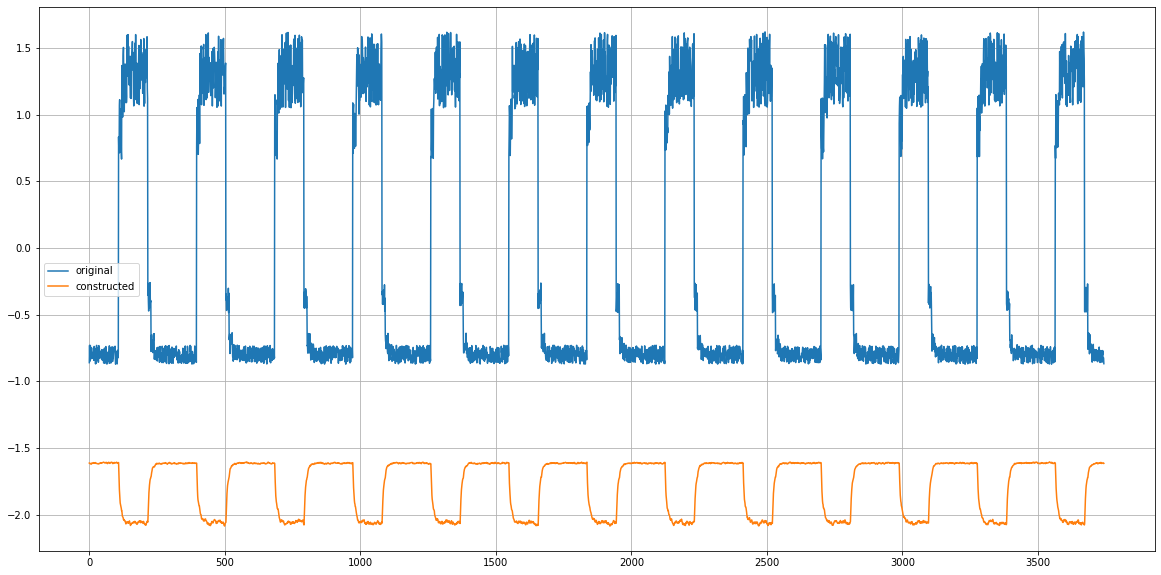

In [34]:
figure1 = plt.figure(figsize=(20,10))
plt.plot(original, label ='original' )
plt.plot(data_decoded, label = 'constructed')
plt.legend()
plt.grid()
plt.show()

In [35]:
svm = OneClassSVM(kernel= 'rbf', nu=0.0001, gamma='scale') 


In [36]:
svm.fit(data_decoded)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.0001, shrinking=True, tol=0.001, verbose=False)

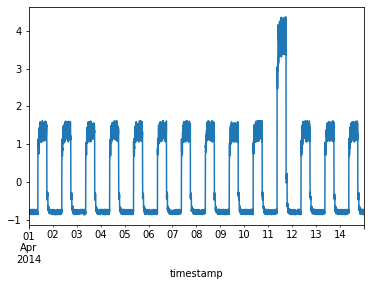

Test input shape:  (3744, 288, 1)


In [37]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


In [38]:
yhat2= sdae.predict(x_test)

In [39]:
x1= []
for i in range(0,yhat.shape[0]):
   x1.append(yhat2[i,0])


test_decoded = np.array(x1)

In [40]:
xx1= []
for i in range(0,x_test.shape[0]):
   xx1.append(x_test[i,0])


test_original = np.array(xx1)

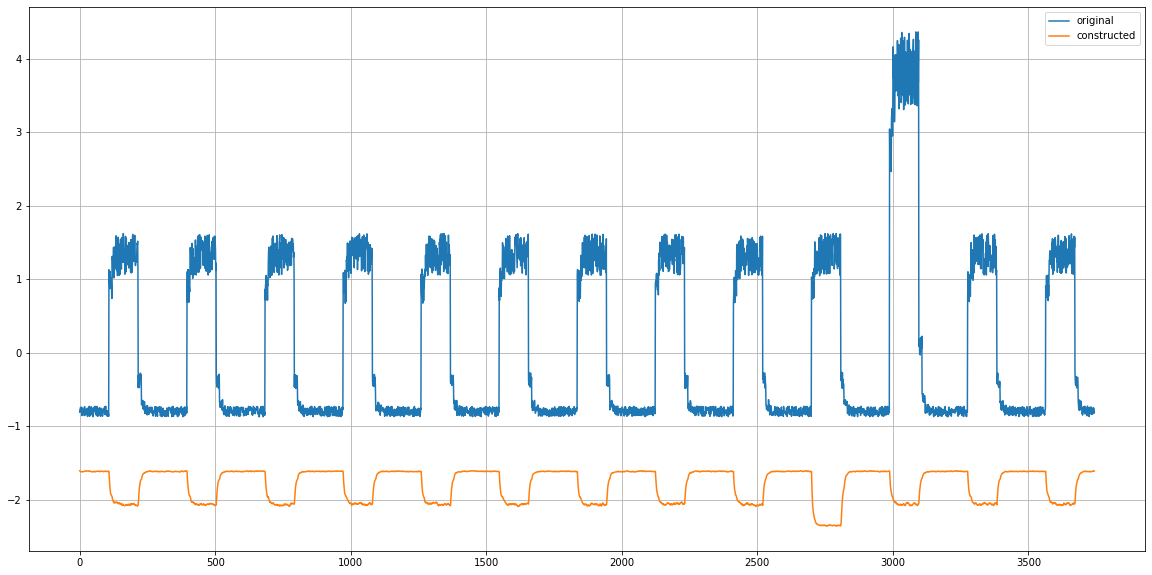

In [41]:
figure1 = plt.figure(figsize=(20,10))
plt.plot(test_original, label ='original' )
plt.plot(test_decoded, label = 'constructed')
plt.legend()
plt.grid()
plt.show()

In [42]:
detection = svm.predict(test_decoded)

In [43]:
anomalous_data_indices = np.where(detection ==-1)

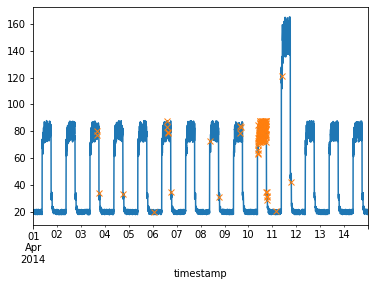

In [44]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, style="x")
plt.show()